# Comparision of genetic algorithms and MIMIC

In [319]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from IPython.display import clear_output

In [233]:
#global k for k deceptive, normally it should be function argument but i dont need to write additional code this way
k = 5

### Benchmarks

In [237]:
@njit
def One_Max(individual):
    return individual.sum()

@njit
def K_Deceptive_One_Max(individual):
    res,cnt = 0,0
    for i in range(individual.shape[0]):
        if individual[i] == 1:
            res += 1
            cnt = 0
        else:
            cnt += 1
            if cnt == k:
                res += cnt + 1
                cnt = 0
    return res

@njit
def Deceptive_One_Max(individual):
    if individual.sum() == 0:
        return individual.shape[0]+1
    else:
        return individual.sum()

### Algorithms

In [238]:
@njit
def gen_cell(p):
    if np.random.uniform(0,1) < p:
        return 1
    else:
        return 0

@njit
def gen_individual(probabilites):
    d = probabilites.shape[0]
    individual = np.zeros(d)
    for i in range(d):
        individual[i] = gen_cell(probabilites[i])
    return individual

@njit
def gen_pop(probabilities,pop_size):
    population = np.zeros((pop_size,probabilities.shape[0]))
    for p in range(pop_size):
        population[p] = gen_individual(probabilities)
    return population

@njit
def evaluate(population,goal_func):
    scores = np.zeros(population.shape[0])
    for i in range(population.shape[0]):
        scores[i] = goal_func(population[i])
    return scores

def UMDA(pop_size,genom_len,fraction,iterations,goal_func):
    probabilities = np.zeros(genom_len) + 0.5
    best_score = 0
    logs = np.zeros((iterations,genom_len))
    for i in range(iterations):
        population = gen_pop(probabilities,pop_size)
        scores = evaluate(population,goal_func)
        best_score = max(best_score,np.max(scores))
        scores_args = np.argsort(-scores)
        logs[i] = probabilities
        probabilities = np.mean(population[scores_args[:fraction]],axis=0)
    return logs,best_score

def PBIL(pop_size,genom_len,fraction,learning_rate,iterations,goal_func):
    probabilities = np.zeros(genom_len) + 0.5
    best_score = 0
    logs = np.zeros((iterations,genom_len))
    for i in range(iterations):
        population = gen_pop(probabilities,pop_size)
        scores = evaluate(population,goal_func)
        best_score = max(best_score,np.max(scores))
        scores_args = np.argsort(-scores)
        logs[i] = probabilities
        probabilities = probabilities * (1-learning_rate) + learning_rate * np.mean(population[scores_args[:fraction]],axis=0)
        for d in range(genom_len):
            if np.random.uniform(0,1) < 0.05:
                probabilities[d] = probabilities[d] * (0.9) + 0.1 * gen_cell(0.5)
    return logs,best_score

def CGA(genom_len,learning_rate,iterations,goal_func):
    probabilities = np.zeros(genom_len) + 0.5
    best_score = 0
    logs = np.zeros((iterations,genom_len))
    for i in range(iterations):
        population = gen_pop(probabilities,2)
        scores = evaluate(population,goal_func)
        best_score = max(best_score,np.max(scores))
        best_one = population[np.argmax(scores)]
        worst_one = population[np.argmin(scores)]
        logs[i] = probabilities
        probabilities += learning_rate * (best_one - worst_one)
    return logs,best_score

### UMDA results

In [189]:
res = UMDA(200,200,50,1000,One_Max)

200.0


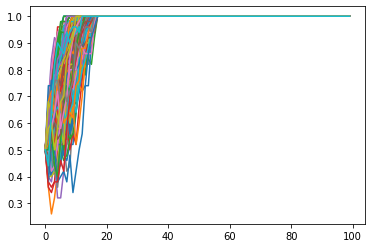

In [190]:
print(res[1])
for i in range(200):
    plt.plot(np.arange(100),res[0][:100,i])

In [191]:
res = UMDA(500,200,50,1000,K_Deceptive_One_Max)

200.0


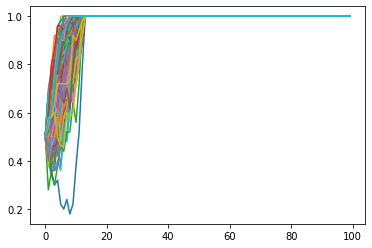

In [192]:
print(res[1])
for i in range(200):
    plt.plot(np.arange(100),res[0][:100,i])

UMDA does works for K deceptive with k = 5 (well it sometimes catches it, but not on all positions), but for higher k it totally does not work.It works pretty good for standard OneMax. UMDA converges really fast.

### PBIL results

In [220]:
res = PBIL(500,200,50,0.1,1000,One_Max)

200.0


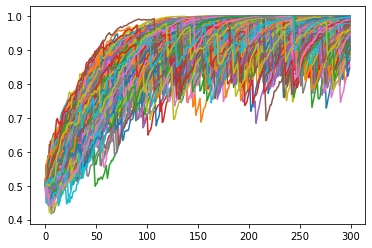

In [221]:
print(res[1])
for i in range(200):
    plt.plot(np.arange(300),res[0][:300,i])

In [229]:
res = PBIL(500,200,50,0.15,1000,K_Deceptive_One_Max)

208.0


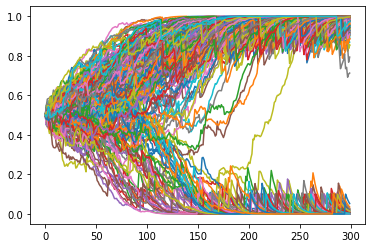

In [230]:
print(res[1])
for i in range(200):
    plt.plot(np.arange(300),res[0][:300,i])

Well difference beetwen PBIL and UMDA is that we somehow control speed of converging. But it is still not working on K Deceptive variant (sometimes for lower k, UMDA even works better beacuse it rises probability of 0 faster than PBIL if it sees 0 one after another).

### CGA results

In [214]:
res = CGA(200,1/200,10000,One_Max)

200.0


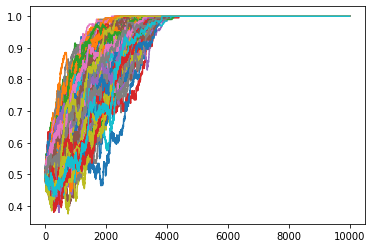

In [215]:
print(res[1])
for i in range(200):
    plt.plot(np.arange(10000),res[0][:,i])

In [217]:
res = CGA(200,0.01,10000,K_Deceptive_One_Max)

200.0


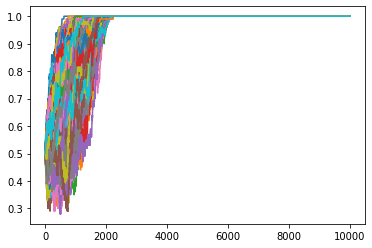

In [218]:
print(res[1])
for i in range(200):
    plt.plot(np.arange(10000),res[0][:,i])

Well CGA is simplest algorithm of all of them, it converges much slower than UMDA in terms of iterations beacuse we draw only two individuals each iteration not 500. It also works worse than other two.

### Conclusion

- One Max is simplest benchmark, so all of algorithms solve it perfectly.
- Deceptive One Max is impossible for all of this three algorithms (given dimensionality of problem is high enough, for genom_len < 5 it can be matter of luck to solve it)
- K Deceptive One Max is hard to solve for this algorithms, UMDA and PBIL can solve it to some degree (given that k is not big - around 5)
- Of course main drawback of CGA is that we draw only two individuals where in UMDA and PBIL we can draw as many as we want (given computional power there are limits), and increasing population size in those two algorithms leads to higher chances of solving Deceptive for higher dimensions (still not something as big as 100), and KDeceptive to bigger degree (more zeros) or/and for higher k values.
- Problem is not with algorithms (I mean UMDA and PBIL and what is worth noticing PBIL is better than UMDA - it is more generic UMDA version, we can always set learning rate to 1 and we have UMDA then), but with deceptive nature of problem (I am speaking of k deceptive beacuse deceptive is just k decpetive with k = d), we need to somehow be lucky enough to get k zeros one after another in sampling, and it happens rather rarely, so even if sometimes we discover that k zeros are nice we will forget it in next iteration where this k zeros will occur somewhere else. So problem is that our goal function has really strong pulling towards all 1 solutions where pulling towards all 0 is much weaker and much more luck depending.

### MIMIC

In [314]:
def gen_cell_v2(p):
    if np.random.uniform(0,1) < p:
        return 1
    else:
        return 0
    
def gen_individual_v2(probs,probs_chain,genom_len):
    indi = np.zeros(genom_len)
    indi[probs_chain[0]] = gen_cell_v2(probs[probs_chain[0],probs_chain[0],0])
    for d in range(genom_len):
        p = probs[probs_chain[d-1],probs_chain[d],int(indi[probs_chain[d-1]])]
        indi[probs_chain[d]] = gen_cell_v2(p)
    return indi
    
def gen_pop_v2(probs,probs_chain,pop_size,genom_len):
    population = np.zeros((pop_size,genom_len))
    for i in range(pop_size):
        population[i] = gen_individual_v2(probs,probs_chain,genom_len)
    return population

def entropy(p):
    return p*np.log(p+1e-10)+(1-p)*np.log(1-p+1e-10)

def pick_best(probs,prev_prob,used,prev,genom_len):
    entropies = np.zeros(genom_len) + 100
    after_prob = np.zeros(genom_len)
    prev = int(prev)
    for i in range(genom_len):
        if used[i] == 1:
            continue
        after_prob[i] = (1-prev_prob)*probs[prev][i][0] + prev_prob*probs[prev][i][1]
        entropies[i] = -entropy(after_prob[i])
    return np.argmin(entropies),after_prob[np.argmin(entropies)]
        
        
def generate_probs_chain(population,probs,genom_len):
    chain = np.zeros(genom_len)
    used = np.zeros(genom_len)
    first = np.argmin(-entropy(np.mean(population,axis=0)))
    prev_prob = np.mean(population,axis=0)[first]
    used[first] = 1
    chain[0] = first
    
    for i in range(1,genom_len):
        choosed,choosed_prob = pick_best(probs,prev_prob,used,chain[i-1],genom_len)
        used[choosed] = 1
        chain[i] = choosed
        prev_prob = choosed_prob
    return chain.astype(int)

def cond_prob(population,i,j):
    if population[population[:,i]==0].size == 0:
        one_given_zero = 0
    else:
        one_given_zero = np.mean(population[population[:,i]==0,j])
    if population[population[:,i]==1].size == 0:
        one_given_one = 0
    else:
        one_given_one = np.mean(population[population[:,i]==1,j])
    return np.array([one_given_zero,one_given_one])

def calculate_cond_probs(population,genom_len):
    cond_probs = np.zeros((genom_len,genom_len,2))
    for i in range(genom_len):
        for j in range(genom_len):
            if i == j:
                cond_probs[i][j] = np.array(np.mean(population[:,i]),np.mean(population[:,i]))
                continue
            cond_probs[i][j] = cond_prob(population,i,j)
    return cond_probs

def evaluate(population,goal_func):
    pop_size = population.shape[0]
    scores = np.zeros(pop_size)
    for i in range(pop_size):
        scores[i] = goal_func(population[i])
    return scores

def MIMIC(pop_size,genom_len,fraction,lr,iterations,goal_func):
    probs = np.zeros((genom_len,genom_len,2)) + 0.5
    probs_chain = np.arange(genom_len)
    population = gen_pop_v2(probs,probs_chain,pop_size,genom_len)
    logs = np.zeros((iterations,3))
    for ite in range(iterations):
        scores = evaluate(population,goal_func)
        logs[ite] = np.array([np.min(scores),np.mean(scores),np.max(scores)])
        if ite%10 == 0:
            clear_output(wait=True)
            print(ite/iterations)
            print(np.max(logs[:ite+1,2]))
            plt.scatter(np.arange(genom_len*genom_len),probs[:,:,0])
            plt.show()
        choosen_ones = population[np.argsort(-scores)[:fraction]]
        probs = probs * (1-lr) + lr * calculate_cond_probs(choosen_ones,genom_len) #lr is learning rate
        probs_chain = generate_probs_chain(choosen_ones,probs,genom_len) #this is permutation of indices
        population = gen_pop_v2(probs,probs_chain,pop_size,genom_len)
    return probs,probs_chain,logs

0.975
119.0


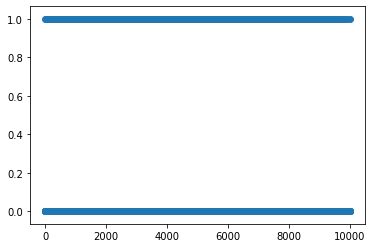

In [315]:
probs,probs_chain,logs = MIMIC(800,100,100,0.15,300,K_Deceptive_One_Max)

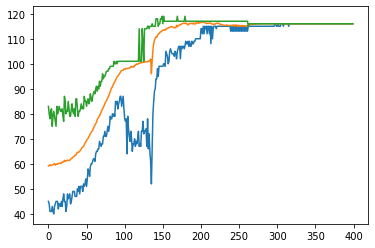

In [316]:
plt.plot(np.arange(400),logs[:,0])
plt.plot(np.arange(400),logs[:,1])
plt.plot(np.arange(400),logs[:,2])
plt.show()

In [318]:
probs[0]

array([[1.08589500e-10, 1.08589500e-10],
       [1.00000000e+00, 1.81891225e-10],
       [4.15040436e-23, 1.42536843e-18],
       [4.21945764e-23, 1.39569557e-19],
       [4.13903192e-23, 1.39566191e-19],
       [3.43067652e-23, 1.39566327e-19],
       [4.15720900e-23, 1.39568734e-19],
       [1.00000000e+00, 1.81891214e-10],
       [4.20102395e-23, 1.39568563e-19],
       [3.97704839e-23, 1.39565880e-19],
       [4.04546811e-23, 1.39558794e-19],
       [3.79276407e-23, 1.39565048e-19],
       [3.93015685e-23, 1.88884657e-18],
       [4.04401174e-23, 1.39568530e-19],
       [3.85188566e-23, 1.39563265e-19],
       [4.16596905e-23, 1.39568619e-19],
       [4.18632242e-23, 1.39564847e-19],
       [3.99817421e-23, 8.89239083e-19],
       [4.20936106e-23, 1.39567977e-19],
       [4.07744803e-23, 1.39568969e-19],
       [3.38562750e-23, 1.39565904e-19],
       [3.85491764e-23, 1.39563646e-19],
       [3.89371323e-23, 1.39566302e-19],
       [3.52728529e-23, 1.39567844e-19],
       [3.679738

MIMIC works much better than other algorithms in case of K deceptive. Without some hardcore tuning of hyperparameters it gets score of 119 where maximal one is 120! Of course we need to pay price of higher computional times, but with progress of GPU parallel calculations it is not a problem beacuse nearly all calculations can be parallelized (exception is getting probability chains, here we need to do it one after another).

# NSGA-II and multi-objective optimization

### Objective functions

In [543]:
#d = 1
def SCH(individual):
    return np.array([individual**2,(individual-2)**2])

#d = 3
def FON(individual):
    first = 1 - np.exp(- np.sum((individual - (1/np.sqrt(3)))**2))
    second = 1 - np.exp(- np.sum((individual + (1/np.sqrt(3)))**2))
    return np.array([first,second])

#d = 3
def KUR(individual):
    first = -10*np.exp(-0.2 * np.sqrt(individual[0]**2 + individual[1]**2))
    first += -10*np.exp(-0.2 * np.sqrt(individual[1]**2 + individual[2]**2))
    second = np.sum(np.abs(individual)**0.8 + 5*np.sin(individual**3))
    return np.array([first,second])

#d = 30
def ZDT1(individual):
    first = individual[0]
    g = 1 + 9*(np.sum(individual)-individual[0])/(individual.shape[0]-1)
    second = g - g*np.sqrt(individual[0]/g)
    return np.array([first,second])

#d = 30
def ZDT2(individual):
    first = individual[0]
    g = 1 + 9*(np.sum(individual)-individual[0])/(individual.shape[0]-1)
    second = g - g*((individual[0]/g)**2)
    return np.array([first,second])

## NSGA-II

### Standard cross function

In [608]:
def find(elem,arr):
    for i in range(len(arr)):
        if elem == arr[i]:
            return True
    return False

def standard_cross(parent_f,parent_s):
    u = np.random.normal(0,1)
    child_f = u*(parent_f-parent_s) + parent_f
    child_s = u*(parent_s-parent_f) + parent_s
    return child_f,child_s

### Mutation

In [620]:
def random_change(individual,p):
    for i in range(individual.shape[0]):
        if np.random.uniform(0,1) < p:
            individual[i] += np.random.normal(loc = 0,scale = np.abs(individual[i]/40))
    return individual

### Pareto frontier

In [621]:
def find_pareto_frontier(scores):
    pareto_frontier = np.zeros(scores.shape[0])
    domination_count = np.zeros(scores.shape[0])
    dominated = []
    for i in range(scores.shape[0]):
        dominated.append([])
        for j in range(scores.shape[0]):
            if i == j:
                continue
            domination = True
            was_lesser = False
            for k in range(scores.shape[1]):
                if scores[i][k] < scores[j][k]:
                    was_lesser = True
                if scores[i][k] > scores[j][k]:
                    domination = False
                    break
            if domination == True and was_lesser == True:
                domination_count[j] += 1
                dominated[i].append(j)
    cnt = 0
    frontier_number = 0
    changes = np.zeros(scores.shape[0])
    while True:
        for i in range(scores.shape[0]):
            if domination_count[i] == 0:
                domination_count[i] = -1
                pareto_frontier[i] = frontier_number
                cnt += 1
                for j in range(len(dominated[i])):
                    changes[dominated[i][j]] += 1
        domination_count -= changes
        changes *= 0
        if cnt == scores.shape[0]:
            break
        frontier_number += 1
    return pareto_frontier           

def find_crowding_distance(scores):
    arg_scores = np.argsort(scores.T)
    crowding_distance = np.zeros(scores.shape[0])
    for i in range(arg_scores.shape[0]):
        crowding_distance[arg_scores[i][0]] = 100000000
    for i in range(1,arg_scores.shape[1]):
        for j in range(arg_scores.shape[0]):
            crowding_distance[arg_scores[j][i]] += np.abs(scores[arg_scores[j][i]][j] - scores[arg_scores[j][i-1]][j])
    return crowding_distance

### SGA funcs

In [650]:
def sort_scores(scores):
    pareto_frontier = find_pareto_frontier(scores).reshape(-1,1)
    crowding_distance = find_crowding_distance(scores).reshape(-1,1)
    merged = np.concatenate((pareto_frontier,-crowding_distance),axis=1)
    #this part is needed for nice and easy argsort
    typed_merged = []
    for row in merged:
        typed_merged.append(tuple(row))
    typed_merged = np.array(typed_merged,dtype = np.dtype([('pareto_frontier',int),('crowding_distance',float)]))
    sorted_merged = np.argsort(typed_merged,order = ('pareto_frontier','crowding_distance'))
    return sorted_merged

def move_to_border(population,left_limit,right_limit):
    for i in range(population.shape[0]):
        for j in range(population.shape[1]):
            population[i][j] = max(left_limit,min(population[i][j],right_limit))
    return population

def fitness_evaluate(scores):
    scores_reduced = np.min(scores,axis=1)
    fitness_values = scores_reduced.max() - scores_reduced
    if fitness_values.sum() > 0:
        fitness_values = fitness_values / fitness_values.sum()
    else:
        fitness_values = np.ones(scores.shape[0]) / scores.shape[0]
    return fitness_values

def random_population(population_size,chromosome_length,left_limit,right_limit):
    current_population = np.zeros((population_size,chromosome_length))
    for i in range(population_size):
        current_population[i, :] = np.random.uniform(left_limit,right_limit,size = chromosome_length)

    return current_population

def evaluate_population(population,population_size,num_of_criterions,eval_function):
    objective_values = np.zeros((population_size,num_of_criterions))
    for i in range(population_size):
        objective_values[i] = eval_function(population[i, :]).reshape(num_of_criterions)
        
    return objective_values

def cross_over(current_population,parent_indices,population_size,crossover_probability,chromosome_length):
    children_population = np.zeros((population_size, chromosome_length), dtype=float)
    
    for i in range(int(population_size/2)):
        if np.random.random() < crossover_probability:
            children_population[2*i, :], children_population[2*i+1, :] = standard_cross(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
        else:
            children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
    if np.mod(population_size, 2) == 1:
        children_population[-1, :] = current_population[parent_indices[-1], :]
    
    return children_population

def replace_mulambda(children_population,current_population,scores,children_scores,population_size):
    scores_merged = np.vstack((scores, children_scores))
    #make dtype array and argsort it
    population_merged = np.vstack((current_population, children_population))

    #I = np.argsort(objective_values)
    I = sort_scores(scores_merged)
    new_population = population_merged[I[:population_size], :].copy()
    new_scores = scores_merged[I[:population_size]].copy()
    
    return new_population,new_scores

### NSGA-II

In [653]:
def NSGA_II(population_size,chromosome_length,number_of_iterations,crossover_probability,mutation_probability,eval_func,left_limit,right_limit):
    costs = np.zeros((number_of_iterations,3,2))

    # generating an initial population
    current_population = random_population(population_size,chromosome_length,left_limit,right_limit)

    # evaluating the objective function on the current population
    objective_values = evaluate_population(current_population,population_size,2,eval_func)
        
    for t in range(number_of_iterations):
        #logging
        costs[t][0][0] = objective_values[:,0].min()
        costs[t][1][0] = objective_values[:,0].mean()
        costs[t][2][0] = objective_values[:,0].max()
        costs[t][0][1] = objective_values[:,1].min()
        costs[t][1][1] = objective_values[:,1].mean()
        costs[t][2][1] = objective_values[:,1].max()
        if t%1 == 0:
            clear_output(wait=True)
            print(t/number_of_iterations)
            plt.scatter(objective_values[:,0],objective_values[:,1])
            plt.show()
        # selecting the parent indices by the roulette wheel method
        fitness_values = fitness_evaluate(objective_values)

        #roullete method
        parent_indices = np.random.choice(population_size, population_size, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = cross_over(current_population,parent_indices,population_size,crossover_probability,chromosome_length)
        children_population = move_to_border(children_population,left_limit,right_limit)
        
        # mutating the children population
        for i in range(population_size):
            children_population[i, :] = random_change(children_population[i, :],mutation_probability)

        # evaluating the objective function on the children population
        children_objective_values = evaluate_population(children_population,population_size,2,eval_func)

        # replacing the current population
        current_population,objective_values = replace_mulambda(children_population,current_population,objective_values,children_objective_values,population_size)
    return costs,current_population

- d = 1 SCH x limit is $[-10^3,10^3]$

- d = 3 FON x limit is $[-4,4]$

- d = 3 KUR x limit is $[-5,5]$

- d = 30 ZDT1 x limit is $[0,1]$

- d = 30 ZDT2 x limit is $[0,1]$

0.99


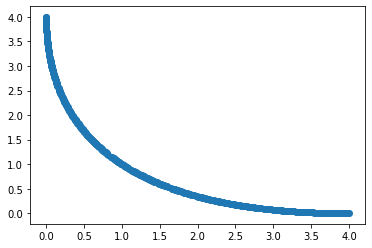

In [654]:
results = NSGA_II(500,1,100,0.9,0.15,SCH,-1000,1000)

0.99


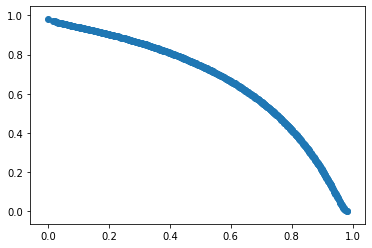

In [655]:
results_FON = NSGA_II(500,3,100,0.9,0.15,FON,-4,4)

0.99


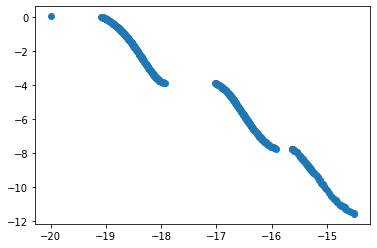

In [656]:
results_KUR = NSGA_II(500,3,100,0.9,0.15,KUR,-5,5)

0.995


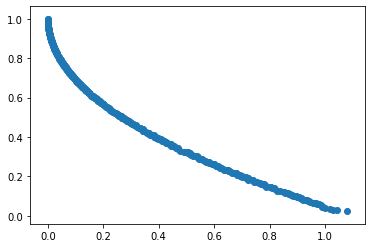

In [659]:
results_ZDT1 = NSGA_II(500,30,200,0.9,0.15,ZDT1,0,1)

0.995


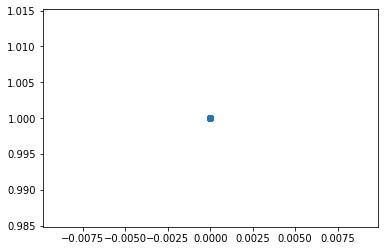

In [662]:
results_ZDT2 = NSGA_II(500,30,200,0.9,0.15,ZDT2,0,1)

Bad results NSGA-II on ZDT2 is fitness evaluate which I wrote fastly without much changes in comparision to standard SGA. We are optimizing two functions and one of them is getting low (in terms of value) scores easly when second one is getting high (in terms of value) scores easly. So my fitness evaluate will assign high probability to individuals which are good on first function where these which are good on second one will have lower probability. It results in plot above. Solution would be changing fitness evaluate to assign probabilites seperately for each function and then take maximum and normalize them (resulting sum of probabilites wont be equal 1).